<a href="https://colab.research.google.com/github/HarshCasper/Brihaspati/blob/master/Reinforcement%20Learning/Tom_and_Jerry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random, math, time
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline

try:
  from google.colab import files
except:
  print("Could not import Google Colab.")

Using TensorFlow backend.


In [0]:
class Environment:

  def __init__(self, grid_size):
      self.grid_size = grid_size
      
      self.cat = imread('https://image.ibb.co/btGeAA/tom.png')
      self.mouse = imread('https://image.ibb.co/njNNxq/jerry.png')
      self.confetti = imread('https://image.ibb.co/ganuAA/tom-and-jerry.png')
      self.dim = 1.5
      
      self.rewards = []
      
  def _update_state(self, action):
      state = self.state
      # 0 = left
      # 1 = right
      # 2 = down
      # 3 = up

      fy, fx, py, px = state
      old_d = abs(fx - px) + abs(fy - py)

      if action == 0:
          if px > 0:
              px -= 1
      if action == 1:
          if px < self.grid_size-1:
              px += 1
      if action == 2:
          if py > 0:
              py-= 1
      if action == 3:
          if py < self.grid_size-1:
              py += 1

      new_d = abs(fx - px) + abs(fy - py)
      self.d = old_d-new_d
      self.time = self.time - 1
      return np.array([fy, fx, py, px])

  def _get_reward(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if fruit_x == player_x and fruit_y == player_y: return 1
    if self.d == 1: return 1
    if self.d == 0: return -1
    if self.d == -1: return -1

  def _is_over(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if self.time == 0: return True
    if fruit_x == player_x and fruit_y == player_y: return True
    return False

  def step(self, action):
    self.state = self._update_state(action)
    reward = self._get_reward()
    self.rewards.append(reward)
    game_over = self._is_over()
    return self.state, reward, game_over
  
  def render(self):
    # Note: there's no promises of efficieny with this method
    # If things are slow, remove it
    
    im_size = (self.grid_size,)*2
    state = self.state
    
    self.fig = plt.figure(figsize=(8, 6), dpi=80)
    self.ax = self.fig.add_subplot(111)
    
    self.ax.clear()
    self.ax.set_ylim((-1, self.grid_size))
    self.ax.set_xlim((-1, self.grid_size))
    #self.ax.axis('off') # uncomment to turn off axes
    self.ax.get_xaxis().set_ticks(range(self.grid_size))
    self.ax.get_yaxis().set_ticks(range(self.grid_size))
    
    xc = state[2]
    yc = state[3]
    xm = state[0]
    ym = state[1]
    
    if state[0] == state[2] and state[1] == state[3]:
      self.ax.imshow(self.confetti, 
                     extent=(-1, self.grid_size,
                             -1, self.grid_size))
    else:
      self.ax.imshow(self.mouse, 
                     extent=(xm-self.dim/4, xm+self.dim/4,
                             ym-self.dim/4, ym+self.dim/4))
      self.ax.imshow(self.cat, 
                     extent=(xc-self.dim/2, xc+self.dim/2,
                             yc-self.dim/2, yc+self.dim/2))
    self.fig.canvas.draw()
    return np.array(self.fig.canvas.renderer._renderer)

  def reset(self, deterministic=True):
    if deterministic:
      # this is an easier environment setup
      fruit_x = 0
      fruit_y = 0
      player_x = self.grid_size - 1
      player_y = self.grid_size - 1
      time = self.grid_size*2
    else:
      generated = False
      while not generated\
      or abs(fruit_x - player_x) + abs(fruit_y - player_y) < self.grid_size/2:
        fruit_x = np.random.randint(0, self.grid_size-1)
        fruit_y = np.random.randint(0, self.grid_size-1)
        player_x = np.random.randint(0, self.grid_size-1)
        player_y = np.random.randint(0, self.grid_size-1)
        time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
        time *= 2
        generated = True

    self.time = time
    self.d = 0
    self.state = np.asarray([fruit_y, fruit_x, player_y, player_x])

    return self.state

Setting up environment
Running random simulation
Resetting environment


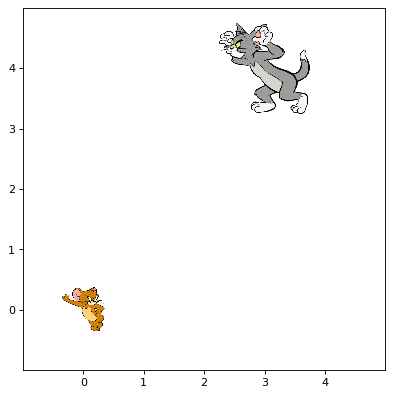

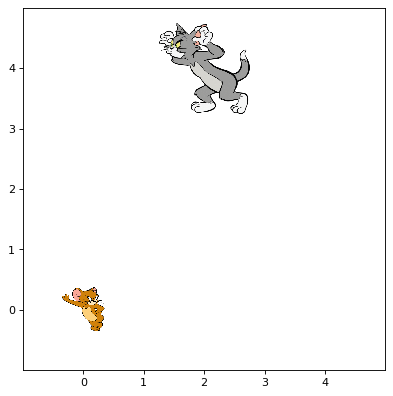

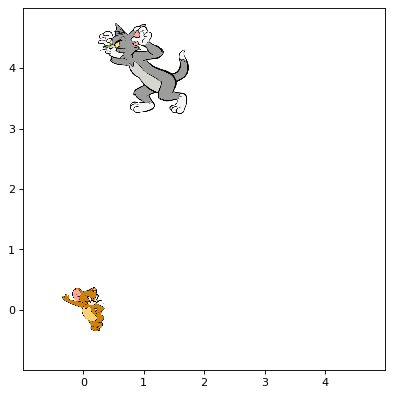

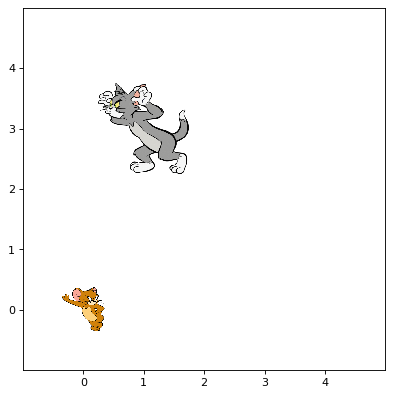

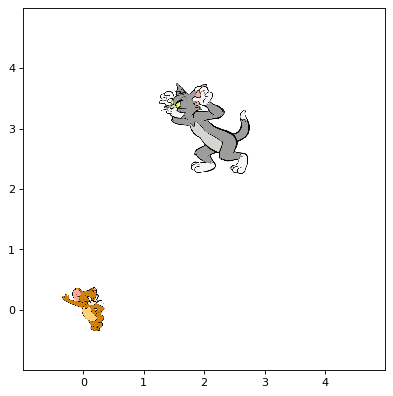

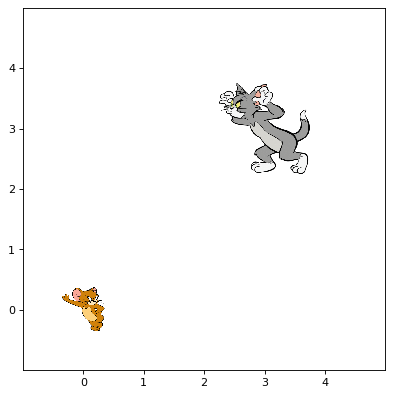

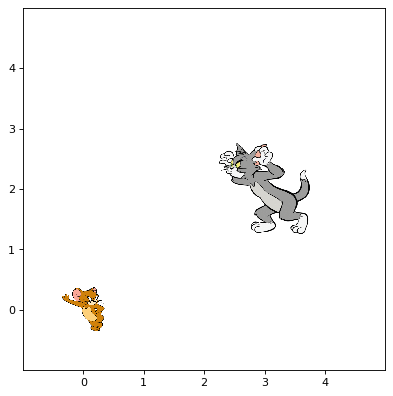

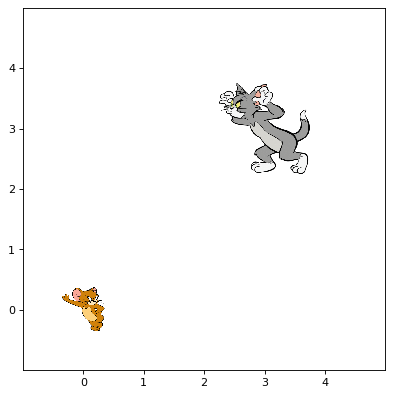

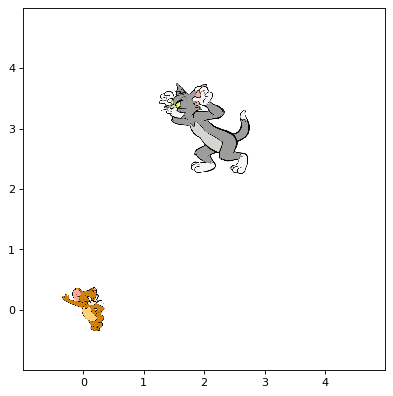

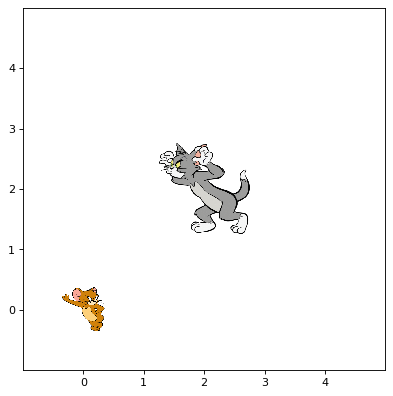

In [0]:
print('Setting up environment')
env = Environment(5)
num_episodes = 1 # number of games we want the agent to play
env.reset()
frames = []
RENDER = True
print('Running random simulation')
for episode in range(num_episodes):
  print('Resetting environment')
  s = env.reset() # Initial state
  while True: 
    a = np.random.choice(range(4)) # choose a random action
    s_, r, done = env.step(a) # apply random action
    
    if RENDER:
      fig = env.render()
      plt.imshow(fig)
      plt.show()
      frames.append(fig)

    if done:
      break

In [0]:
class Brain:
  """The 'brain' of the agent, where the model is created and held.
  
  state_dim (int): the size of the observation space
  action_dim (int): the size of the action space
  
  """
  def __init__(self, state_dim, action_dim, weights=None):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.model = self._createModel()
    if weights:
      self.model.load_weights("brain.h5")

  def _createModel(self):
    # Creates a Sequential Keras model
    # This acts as the Deep Q-Network (DQN)
    
    model = Sequential()

    ### START CODE HERE ### (≈ 3 lines of code)

    model.add(Dense(128 , activation='relu' , input_dim= 4))
    model.add(Dense(128, activation='relu')  )
    #model.add(Dense(256, activation = 'relu'))
    model.add(Dense(4, activation='linear')   )       
    
    
    ### END CODE HERE ###

    opt = RMSprop(lr=0.00025)
    model.compile(loss='mse', optimizer=opt)

    return model

  def train(self, x, y, epoch=1, verbose=0):
    self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)

  def predict(self, s):
    return self.model.predict(s)

  def predictOne(self, s):
    return self.predict(s.reshape(1, self.state_dim)).flatten()

In [0]:
class Memory:   # stored as ( s, a, r, s_ )
  """The agent's 'memory', where experiences are stored
  """

  def __init__(self, capacity):
    self.capacity = capacity
    self.samples = []

  def add(self, sample):
    # a sample should be an array [s, a, r, s_]
    # s: current state
    # a: current action
    # r: current reward
    # s_: next state
    self.samples.append(sample)        

    if len(self.samples) > self.capacity:
        self.samples.pop(0)

  def sample(self, n):
    n = min(n, len(self.samples))
    return random.sample(self.samples, n)

In [0]:
class Agent:
  """The agent, which learns to navigate the environment
  
  """
  
  def __init__(self, state_dim, action_dim, memory_capacity = 10000,
              batch_size = 64, gamma = 0.01, lamb = 0.001,
               max_epsilon = 1., min_epsilon = 0.01):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.batch_size = batch_size
    self.gamma = gamma # discount rate, to calculate the future discounted reward
    self.lamb = lamb
    self.max_epsilon = max_epsilon
    self.epsilon = max_epsilon
    self.min_epsilon = min_epsilon

    self.brain = Brain(state_dim, action_dim)
    self.memory = Memory(memory_capacity)
    self.steps = 0
    self.epsilons = []

  def act(self, s, verbose=False):
    """The policy of the agent:
    Here, we determine if we explore (take a random action) based on epsilon.
    If not, we have the model predict the Q-Values for the state,
    then take the action which maximizes those values.
    """
    if random.random() < self.epsilon:
      if verbose:
        print("Random Action.")
      return random.randint(0, self.action_dim-1)
    else:
      actions = self.brain.predictOne(s)  #transfers control to brain
      if verbose:
        print("Actions:", actions)
      return np.argmax(actions)

  def observe(self, sample):  # in (s, a, r, s_) format
    """The agent observes an event.
    We pass a sample (state, action, reward, next state) to be stored in memory.
    We then increment the step count and adjust epsilon accordingly.
    """
    self.memory.add(sample)        

    # slowly decrease Epsilon based on our eperience
    self.steps += 1
    
    ### START CODE HERE ### (≈ 1 line of code)
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-(self.lamb * self.steps))
    ### END CODE HERE ###
    
    self.epsilons.append(self.epsilon)

  def replay(self):
    """The agent learns based on previous experiences.
    We sample observations (state, action, reward, next state) from memory.
    We train the model based on these observations.
    """
    
    # Random sample of experiences
    batch = self.memory.sample(self.batch_size)
    batch_size = len(batch)

    # Extracting states ('current' and 'next') from samples
    no_state = np.zeros(self.state_dim)
    states = np.array([ o[0] for o in batch ])
    states_next = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])

    # Estimating Q-Values for states
    q_vals = self.brain.predict(states)
    q_vals_next = self.brain.predict(states_next)

    # Setting up training data
    x = np.zeros((batch_size, self.state_dim))
    y = np.zeros((batch_size, self.action_dim))
    
    for i in range(batch_size):
      # Observation
      obs = batch[i]
      
      # State, Action, Reward, Next State
      st = obs[0]; act = obs[1]; rew = obs[2]; st_next = obs[3]
      
      # Estimated Q-Values for Observation
      t = q_vals[i]

      ### START CODE HERE ### (≈ 4 line of code)
      #if (i == batch_size - 1):
      #if st_next == NULL:
      #print (q_vals_next)
      if st_next is None:
      #  print("next state none for state ",obs[0])
        t[act] = rew
        
      else:
      #print("state is not None for ",obs[0])
        t[act] = rew + self.gamma*(np.amax(q_vals_next))
      

    
    
      ### END CODE HERE ###

      # Set training data
      x[i] = st
      y[i] = t

    # Train
    self.brain.train(x, y)

In [0]:
print('Setting up environment')
env = Environment(5)

state_dim = 4
action_dim = 4 # left, right, up, down
print('Setting up agent')
MAX_EPSILON = 1 # the rate in which an agent randomly decides its action
MIN_EPSILON = 0.05 # min rate in which an agent randomly decides its action
LAMBDA = 0.00005      # speed of decay for epsilon
num_episodes = 10000 # number of games we want the agent to play

VERBOSE = False
agent = Agent(state_dim, action_dim, lamb=LAMBDA,
              max_epsilon=MAX_EPSILON, min_epsilon=MIN_EPSILON)
env.reset()
episode_rewards = []
epsilons = []
t0 = time.time()
frames = []

print('Running simulation')
for episode in range(num_episodes):
  s = env.reset() # Initial state
  if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
  R = 0
  while True: 
    a = agent.act(s, verbose=VERBOSE)

    s_, r, done = env.step(a)

    if done: # terminal state
        s_ = None

    agent.observe( (s, a, r, s_) )
    agent.replay()

    s = s_
    R += r
    
    if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
    
    if VERBOSE:
      print("Action:", a)
      print("Reward:", r)

    if done:
      break
      
  epsilons.append(agent.epsilon)
  episode_rewards.append(R)
  
  if episode % 100 == 0:
    print('Episode {}'.format(episode))
    print('Time Elapsed: {0:.2f}s'.format(time.time() - t0))
    print('Epsilon {}'.format(epsilons[-1]))
    print('Last Episode Reward: {}'.format(R))
    print('Episode Reward Rolling Mean: {}'.format(np.mean(episode_rewards[:-100])))
    print('-'*10)

agent.brain.model.save("brain.h5")

Setting up environment
Setting up agent




Running simulation










/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Episode 0
Time Elapsed: 1.44s
Epsilon 0.9995251187302109
Last Episode Reward: 4
Episode Reward Rolling Mean: nan
----------


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100
Time Elapsed: 5.98s
Epsilon 0.9532162322387105
Last Episode Reward: 4
Episode Reward Rolling Mean: 4.0
----------
Episode 200
Time Elapsed: 10.58s
Epsilon 0.9091658567921319
Last Episode Reward: 2
Episode Reward Rolling Mean: 0.25742574257425743
----------
Episode 300
Time Elapsed: 15.20s
Epsilon 0.8672638435070424
Last Episode Reward: 2
Episode Reward Rolling Mean: 0.11940298507462686
----------
Episode 400
Time Elapsed: 19.78s
Epsilon 0.8274442867669949
Last Episode Reward: 4
Episode Reward Rolling Mean: 0.27906976744186046
----------


In [0]:
 plt.figure(figsize=(8, 6), dpi=80)
plt.title("Epsilon")
plt.xlabel("Episode")
plt.ylabel("Epsilon value")
plt.plot(epsilons)

In [0]:
smoothing = 50
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("{} MA Reward".format(smoothing))
episode_ma = np.convolve(episode_rewards, 
                         np.ones((smoothing,))/smoothing, mode='valid')
plt.plot(episode_ma)

In [0]:
!apt install ffmpeg
!which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'

In [0]:
fig, ax = plt.subplots()
plt.axis('off')
l = ax.imshow(frames[0])

def animate(i):
    l.set_data(frames[i])

Writer = animation.writers['ffmpeg']
writer = Writer(fps=12, metadata=dict(artist='Me'))
ani = animation.FuncAnimation(fig, animate, frames=len(frames))

ani.save('animation.mp4', writer=writer, dpi=220)
time.sleep(20) # let it process (only necessary in Colab)

In [0]:
files.download('animation.mp4')